## BQML - data prep

In [30]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'
REGION = "us-central1"

# VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com'
VERTEX_SA = 'jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")
print(f"REGION: {REGION}")
print(f"VERTEX_SA: {VERTEX_SA}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1
REGION: us-central1
VERTEX_SA: jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com


In [31]:
VERSION='jtv4'

In [32]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-1'
SERIES = f'{VERSION}-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

BQ_SOURCE1 = 'bigquery-public-data.new_york.citibike_trips'
BQ_SOURCE2 = 'bigquery-public-data.new_york.citibike_stations'
viz_limit = 12

### packages

In [33]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

from google.cloud import aiplatform as vertex_ai

### clients

In [34]:
bq_client = bigquery.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID, 
    location=REGION,
    # credentials=credentials
)

## Dataset

In [35]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us' #REGION
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq_client.create_dataset(dataset = ds, exists_ok = True)

In [36]:
ds.dataset_id

'jtv4_forecasting'

In [37]:
ds.full_dataset_id

'hybrid-vertex:jtv4_forecasting'

In [38]:
# datasets = list(bq_client.list_datasets())
# for d in datasets:
#     print(d.dataset_id)

In [39]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE1}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,1229,2016-04-22 16:34:41+00:00,2016-04-22 16:55:10+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,3122,48 Ave & 5 St,40.744363,-73.955873,19469,Customer,<NA>,unknown
1,3142,2016-05-16 16:10:26+00:00,2016-05-16 17:02:49+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,3122,48 Ave & 5 St,40.744363,-73.955873,23466,Subscriber,1986,male
2,1586,2015-10-11 15:28:46+00:00,2015-10-11 15:55:12+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,3122,48 Ave & 5 St,40.744363,-73.955873,22896,Customer,<NA>,unknown
3,816,2015-10-09 12:00:51+00:00,2015-10-09 12:14:27+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,3122,48 Ave & 5 St,40.744363,-73.955873,23533,Subscriber,1989,male
4,1959,2015-10-14 20:24:30+00:00,2015-10-14 20:57:09+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,3122,48 Ave & 5 St,40.744363,-73.955873,23110,Subscriber,1984,male


In [40]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE2}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,495,W 47 St & 10 Ave,6824.07,40.762699,-73.993012,71,"KEY, CREDITCARD",0,False,0,0,0,0,True,True,True,False,1970-01-02 00:00:00+00:00
1,3171,Amsterdam Ave & W 82 St,7360.10,40.785247,-73.976673,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
2,3603,31 Ave & 30 St,6857.09,40.764700,-73.924031,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
3,3733,Avenue C & E 18 St,5769.04,40.730563,-73.973984,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
4,3792,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,70,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00


## Create a Source Table or View

In [41]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender
        FROM `{BQ_SOURCE1}`
        WHERE start_station_name LIKE '%Central Park%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `{BQ_SOURCE2}`
        WHERE name LIKE '%Central Park%'
        GROUP BY name
    )
SELECT * EXCEPT(name)
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bq_client.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

1.866

### Review time series data

In [42]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

In [43]:
query = f"""
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq_client.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,num_trips,FromDate,ToDate
0,Central Park North & Adam Clayton Powell Blvd,4808,2016-09-01,2016-09-30
1,Central Park S & 6 Ave,172220,2013-07-01,2016-09-30
2,Central Park W & W 96 St,5905,2016-08-04,2016-09-30
3,Central Park West & W 100 St,2245,2016-08-08,2016-09-30
4,Central Park West & W 102 St,2851,2016-08-08,2016-09-30
5,Central Park West & W 68 St,35192,2015-09-01,2016-09-30
6,Central Park West & W 72 St,44574,2015-09-01,2016-09-30
7,Central Park West & W 76 St,27919,2015-09-09,2016-09-30
8,Central Park West & W 85 St,43895,2015-10-07,2016-09-23
9,Grand Army Plaza & Central Park S,163815,2013-07-01,2016-09-30


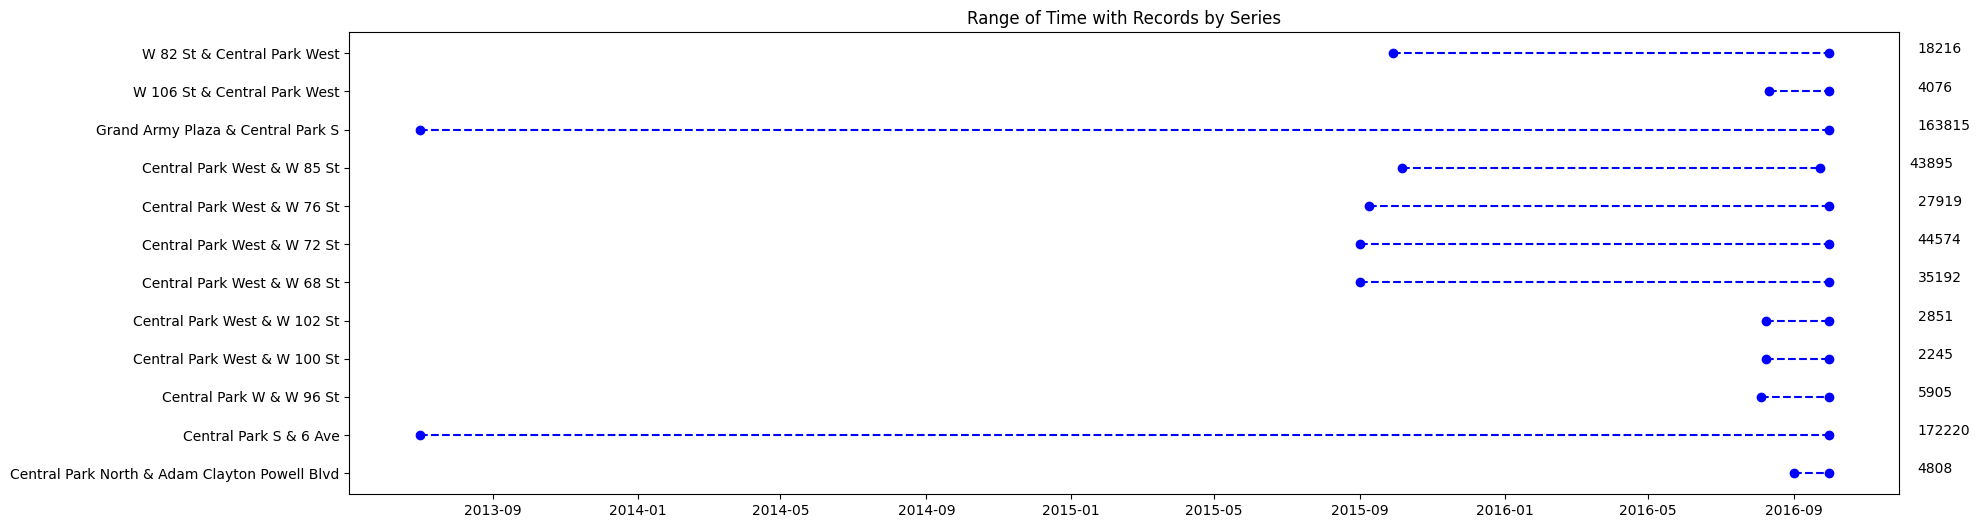

In [44]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

In [45]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq_client.query(query).to_dataframe()

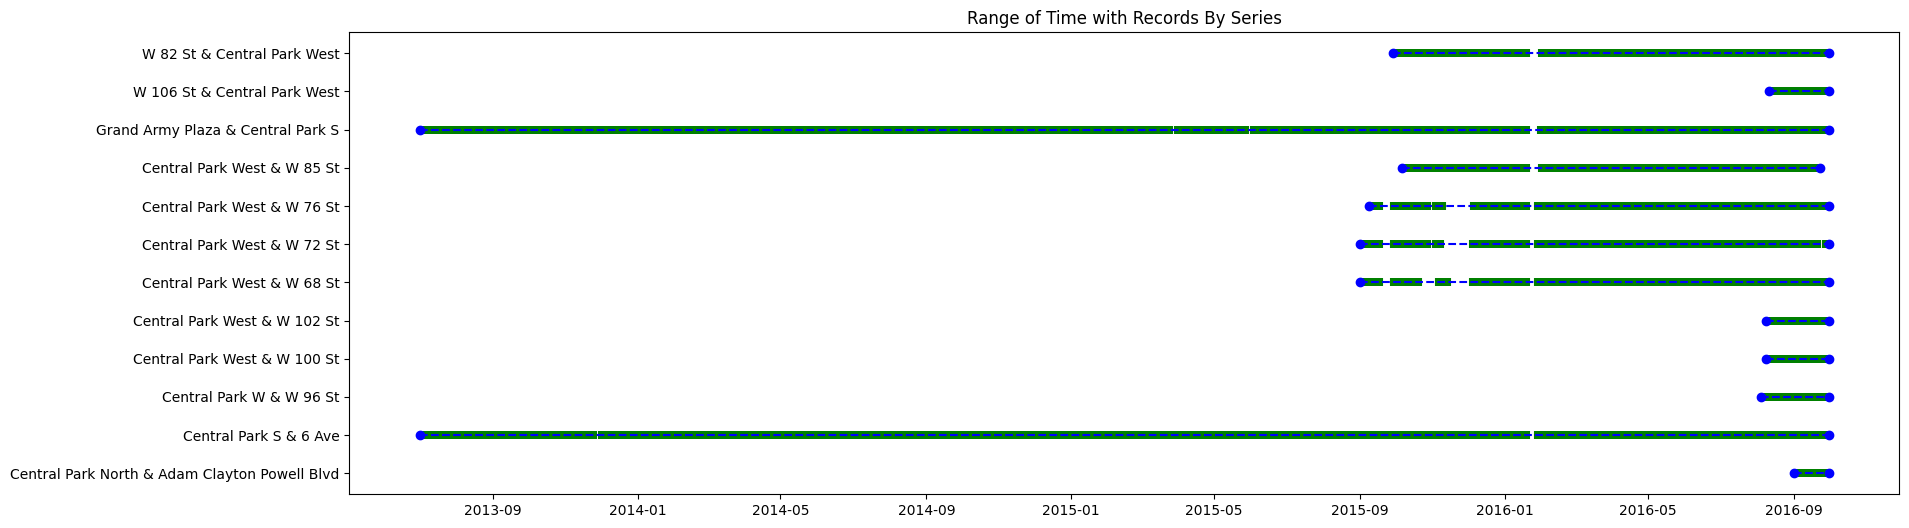

In [46]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### train/test/valid splits

In [47]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
forecast_val_length = 14

In [48]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


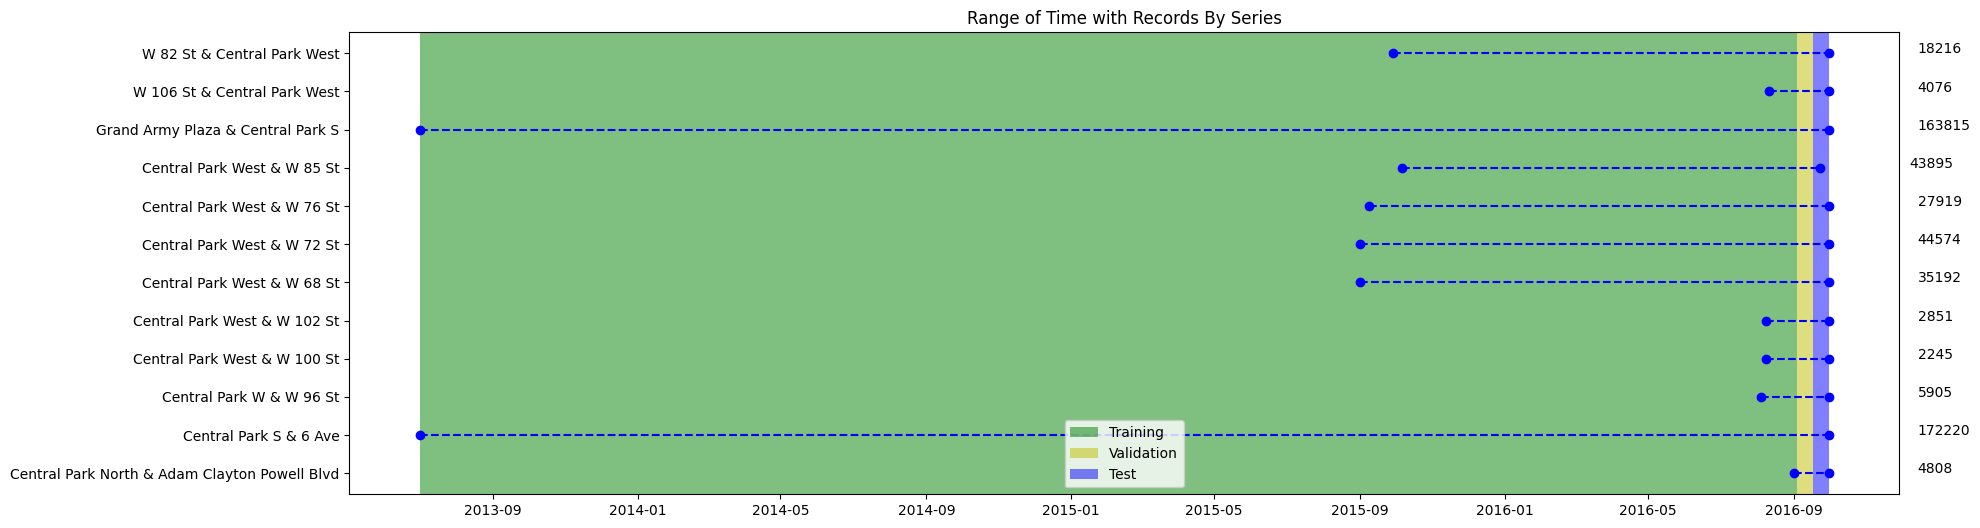

In [49]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create BigQuery Table for Forecasting

In [50]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS splits
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.862

### review forecasting data

In [51]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,num_trips
0,Central Park North & Adam Clayton Powell Blvd,2,14,14,4808
1,Central Park S & 6 Ave,1149,14,14,172220
2,Central Park W & W 96 St,30,14,14,5905
3,Central Park West & W 100 St,26,14,14,2245
4,Central Park West & W 102 St,26,14,14,2851
5,Central Park West & W 68 St,331,14,14,35192
6,Central Park West & W 72 St,334,14,13,44574
7,Central Park West & W 76 St,327,14,14,27919
8,Central Park West & W 85 St,324,14,7,43895
9,Grand Army Plaza & Central Park S,1152,14,13,163815


In [52]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       4055
VALIDATE     168
TEST         159
dtype: int64

In [53]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

4382

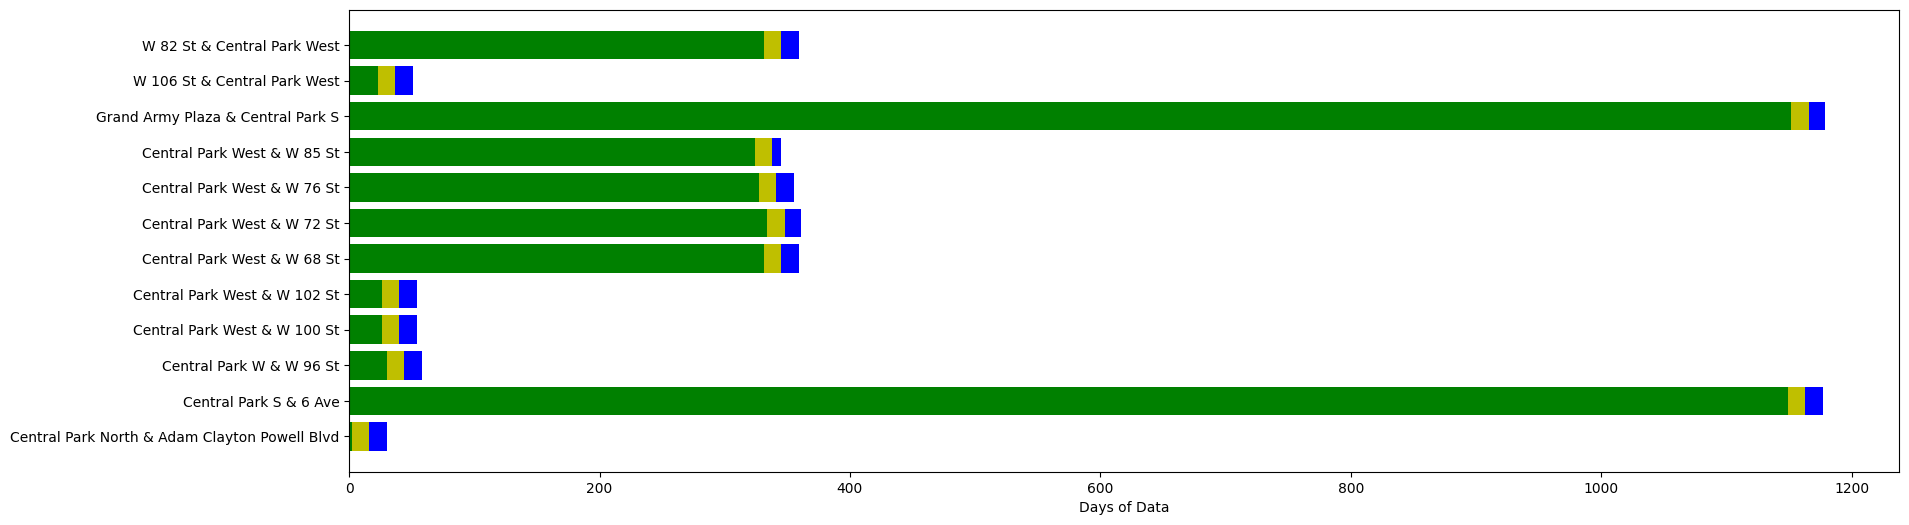

In [54]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

### Validation Check: Extract dates for splits from source


In [55]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


### check for duplicates

In [56]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq_client.query(query).to_dataframe()

,start_station_name,starttime,records


In [57]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq_client.query(query).to_dataframe()

# plot time series

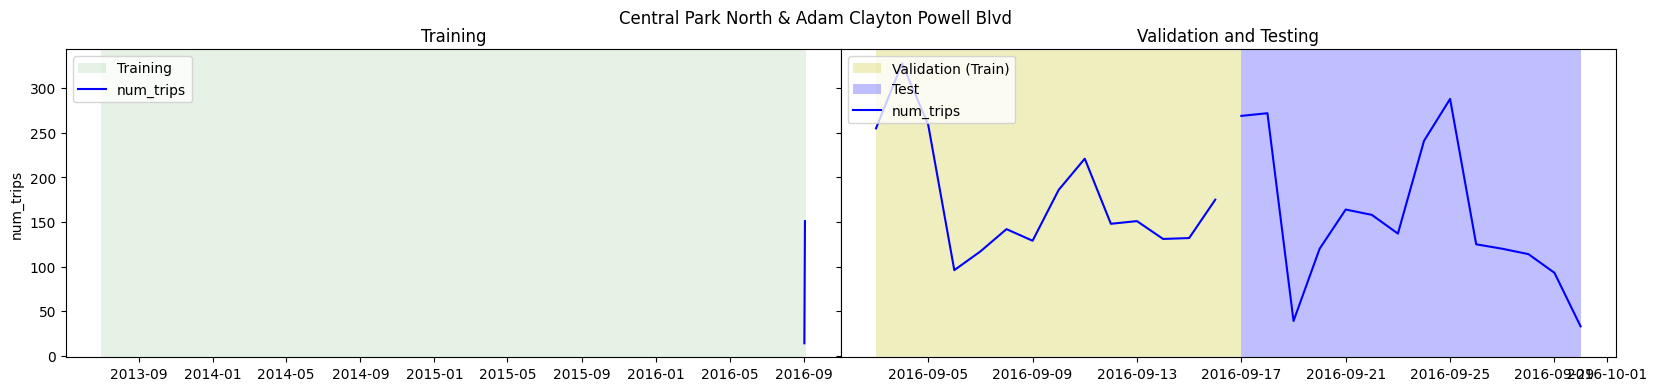

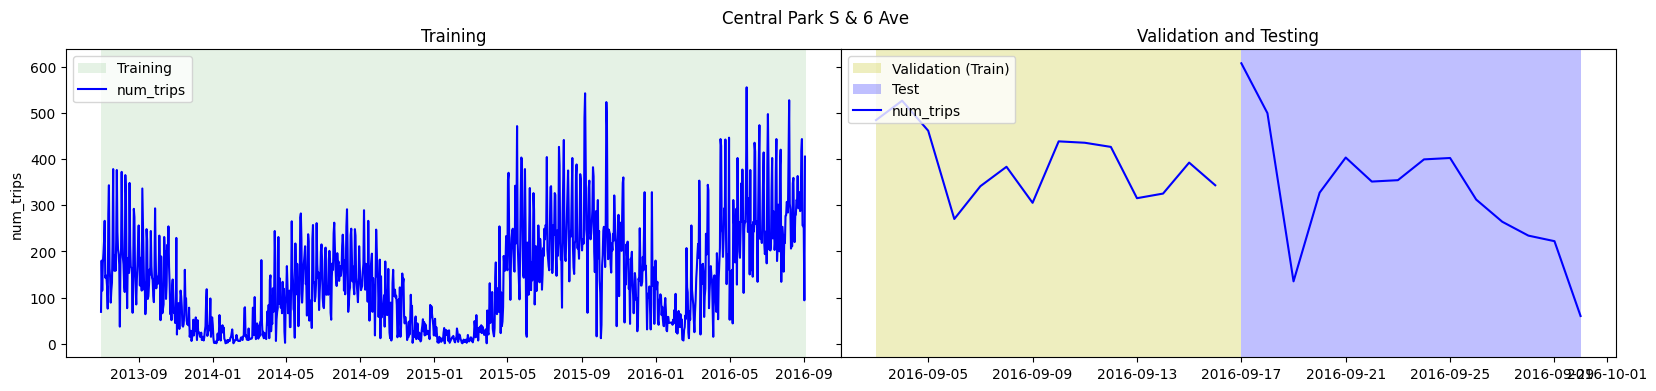

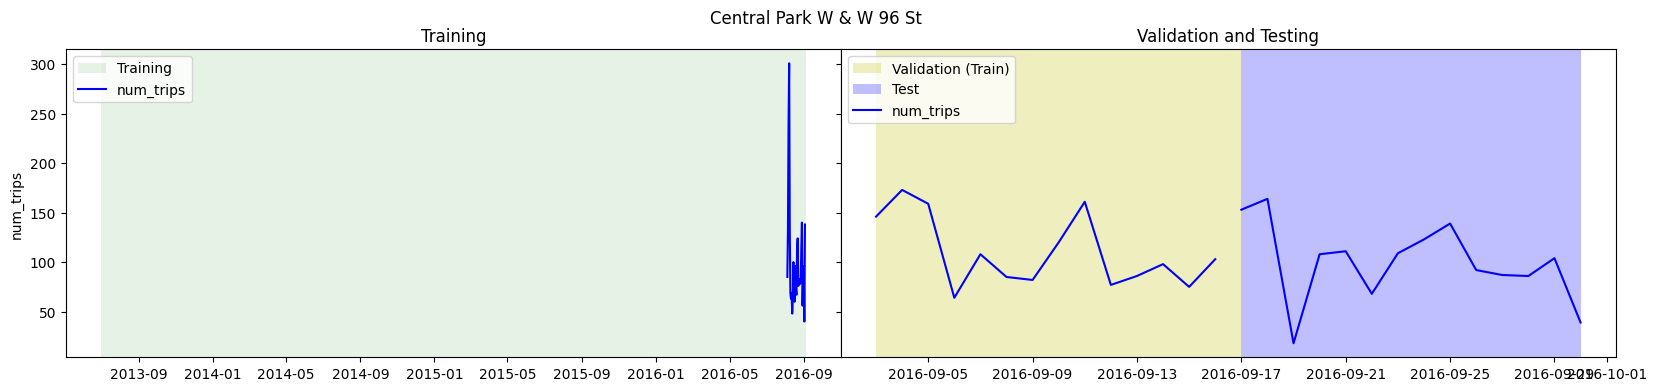

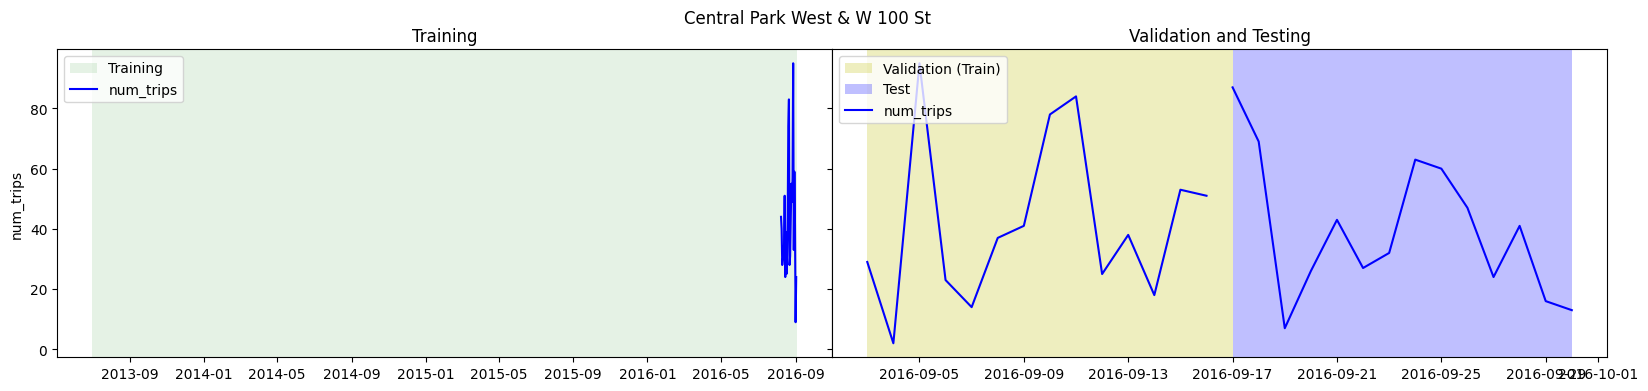

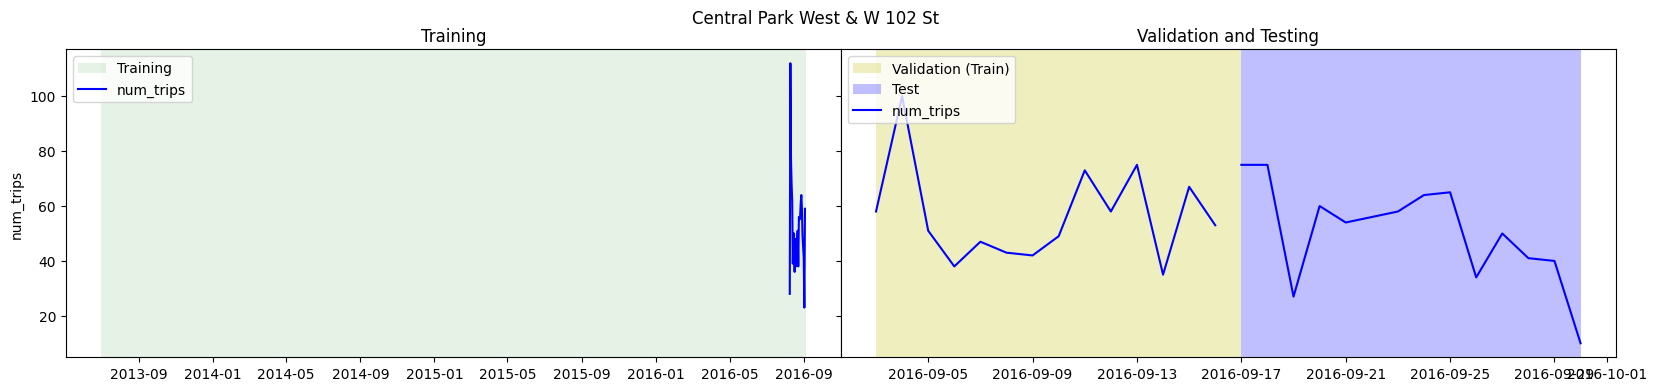

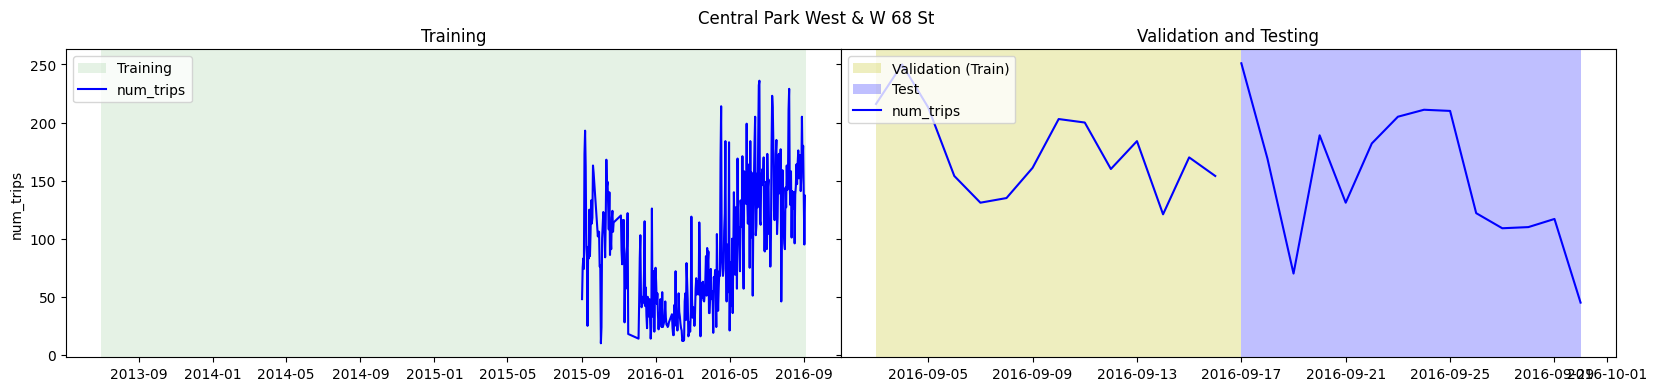

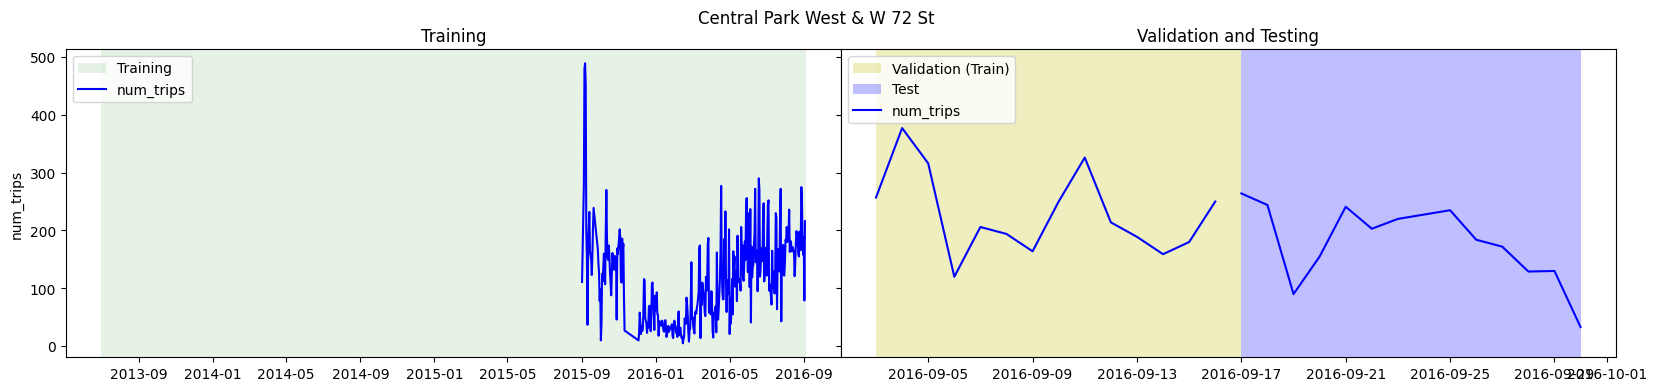

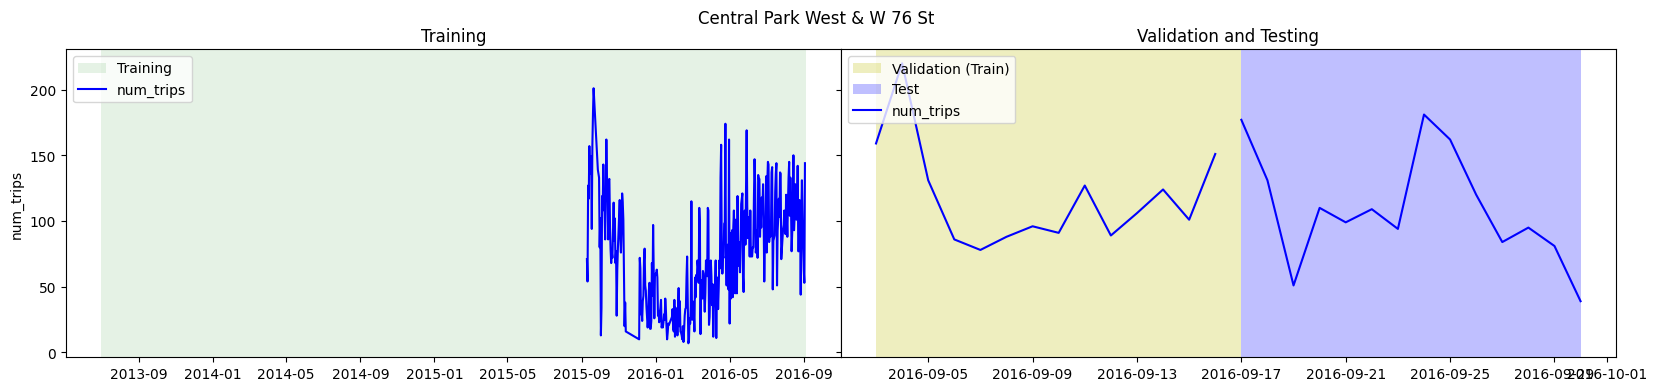

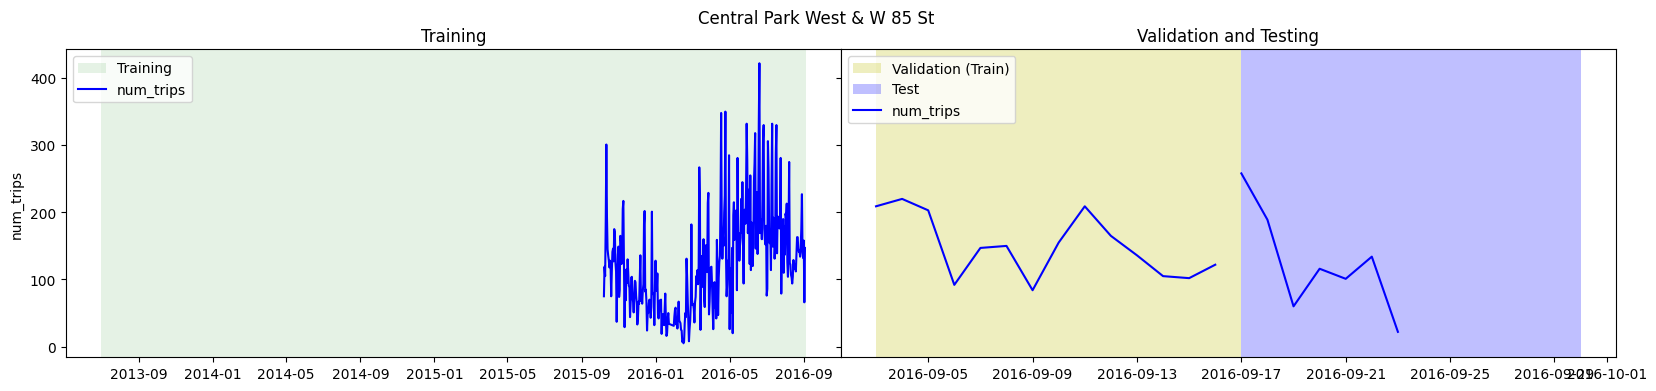

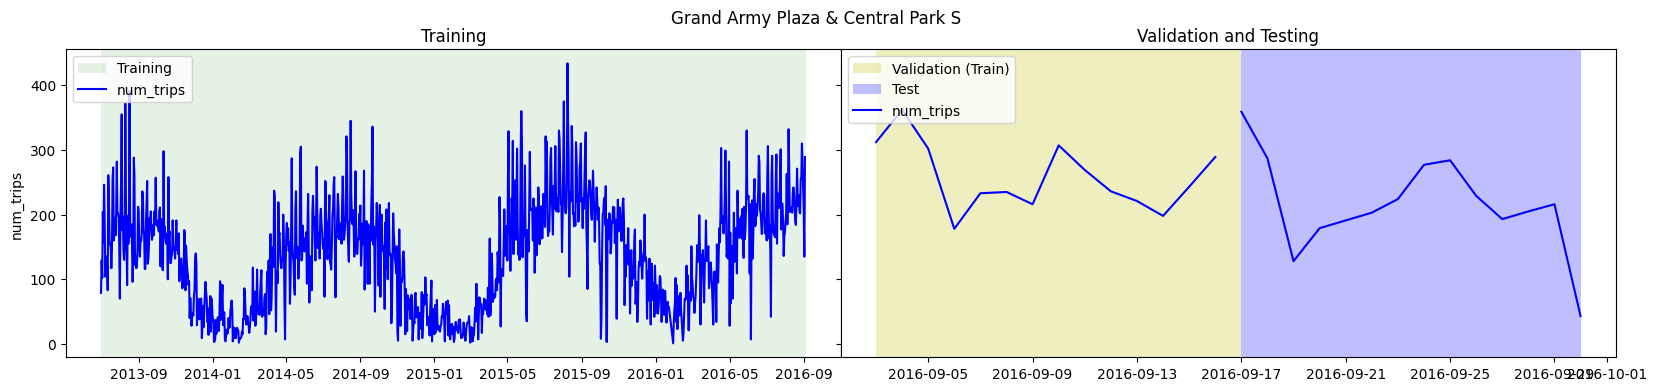

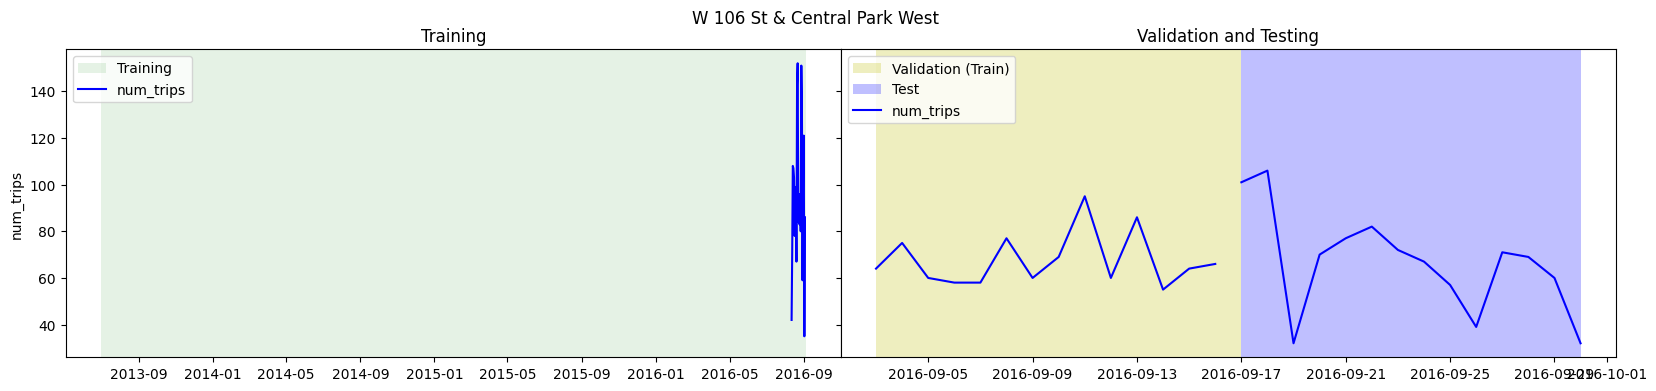

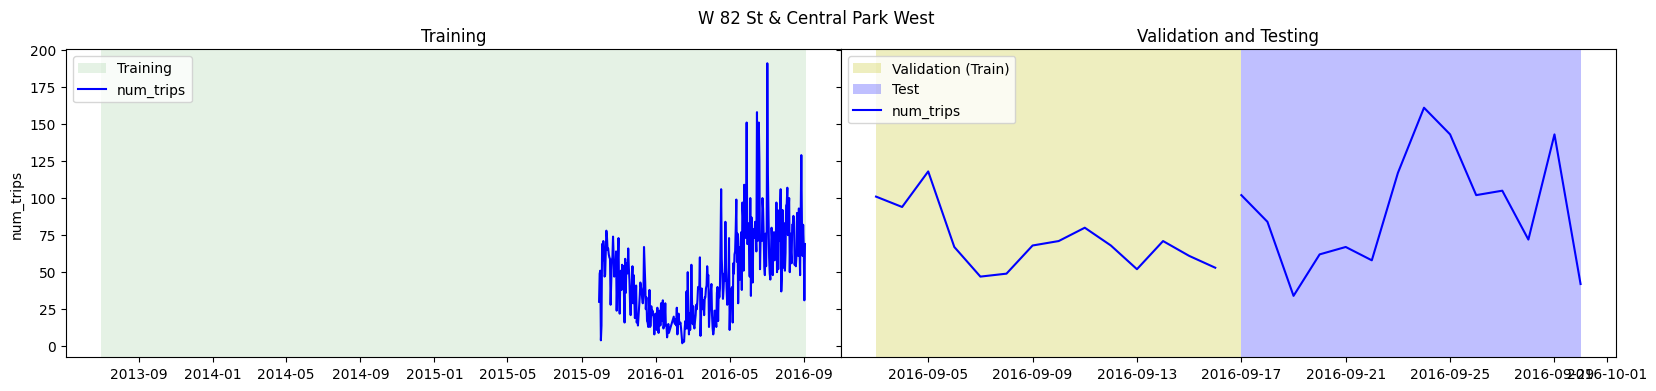

In [58]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

## overlay covariates

In [31]:
# series = rawSeries[SERIES_COLUMN].unique().tolist()
# for s, st in enumerate(series):
#     if s <= viz_limit:
#         # setup plot area
#         fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
#         fig.subplots_adjust(wspace=0)

#         # data
#         traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
#         valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
#         testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

#         # regions
#         axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
#         axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
#         axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

#         # lines and dots
#         axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
#         axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
#         axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

#         # labels
#         axes[0].set_ylabel(TARGET_COLUMN)
#         axes[0].set_title('Training')
#         axes[1].set_title('Validation and Testing')
#         axes[1].legend(loc = 'upper left')
#         axes[0].legend(loc = 'upper left')
#         plt.suptitle(st)

#         # overaly covariates (up to 5):
#         for c, cov in enumerate(COVARIATE_COLUMNS):
#             colors = ['g','c','m','b','r']
#             if c<5:
                
#                 twin = axes[0].twinx()
#                 twin.plot(traindf[TIME_COLUMN], traindf[cov], color = colors[c], label = f'{cov}')
                
#                 twin = axes[1].twinx()
#                 twin.set_ylabel(cov, color = colors[c])
#                 twin.tick_params(axis = 'y', labelcolor = colors[c])
#                 twin.spines.right.set_position(("axes", 1+.05*c))
#                 twin.plot(valdf[TIME_COLUMN], valdf[cov], color = colors[c], label = f'{cov}')
#                 twin.plot(testdf[TIME_COLUMN], testdf[cov], color = colors[c], label = f'{cov}')
        
#         # display result
#         plt.show()